In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [2]:
import warnings
warnings.filterwarnings("ignore")
#Import Os and Basis Libraries
import cv2
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Matplot Images
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
# Tensflor and Keras Layer and Model and Optimize and Loss
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import *
from tensorflow.keras.losses import BinaryCrossentropy
#Kernel Intilizer
from tensorflow.keras.initializers import he_normal
# import tensorflow_hub as hub
from tensorflow.keras.optimizers import Adam
#PreTrained Model VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import Xception
#Image Generator DataAugmentation
# Changed import statement to use tf.keras.preprocessing.image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
#Early Stopping
from tensorflow.keras.callbacks import EarlyStopping
# import splitfolders

Loading Data

In [3]:
directory = '/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset'


In [4]:
# List of categories (subfolder names)
categories = ["Sandal", "Shoe"]

# Initialize lists to store filenames and categories
filenames = []
category_labels = []

# Iterate through the categories
for category in categories:
    # Path to the current category folder
    category_folder = os.path.join(directory, category)

    # Check if the category folder exists
    if not os.path.exists(category_folder):
        print(f"Error: Category folder '{category_folder}' not found.")
        continue  # Skip to the next category if this one is missing

    # List all filenames in the category folder
    category_filenames = os.listdir(category_folder)

    # Append filenames and corresponding category labels
    filenames.extend(category_filenames)
    category_labels.extend([category] * len(category_filenames))

# Create DataFrame
df = pd.DataFrame({
    'filename': filenames,
    'category': category_labels
})
print(df.head())

            filename category
0  Sandal (4349).jpg   Sandal
1  Sandal (4228).jpg   Sandal
2  Sandal (4602).jpg   Sandal
3   Sandal (457).jpg   Sandal
4  Sandal (4457).jpg   Sandal


In [5]:
# convert the filenames and class names to NumPy arrays
filenames = np.array(filenames)
labels = np.array(category_labels)

Spliting Data

In [6]:
!pip install split-folders


In [7]:
!ls "/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset"


output	Sandal	Shoe


In [8]:
input_folder = '/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset'
output_folder = '/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset/output'


In [9]:
import splitfolders  # or import split_folders

# Split the dataset into train, validation, and test sets (80%, 10%, 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(0.8, 0.1, 0.1))


Copying files: 10000 files [48:22,  3.45 files/s]


Image Data Generator

In [10]:
import splitfolders  # or import split_folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ... (Previous code to split folders) ...

img_size = (224, 224)
batches = 32

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

# Use flow_from_directory
train_gen = tr_gen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset/output/train',  # Path to your training images
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    batch_size=batches
)

test_gen = ts_gen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset/output/test',  # Path to your test images
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=False,
    batch_size=batches
)

val_gen = ts_gen.flow_from_directory(
    '/content/drive/My Drive/Colab Notebooks/Shoe vs Sandal vs Boot Dataset/output/val',  # Path to your validation images
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    shuffle=True,
    batch_size=batches
)


Found 8000 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.
Found 1000 images belonging to 3 classes.


sample from training Data

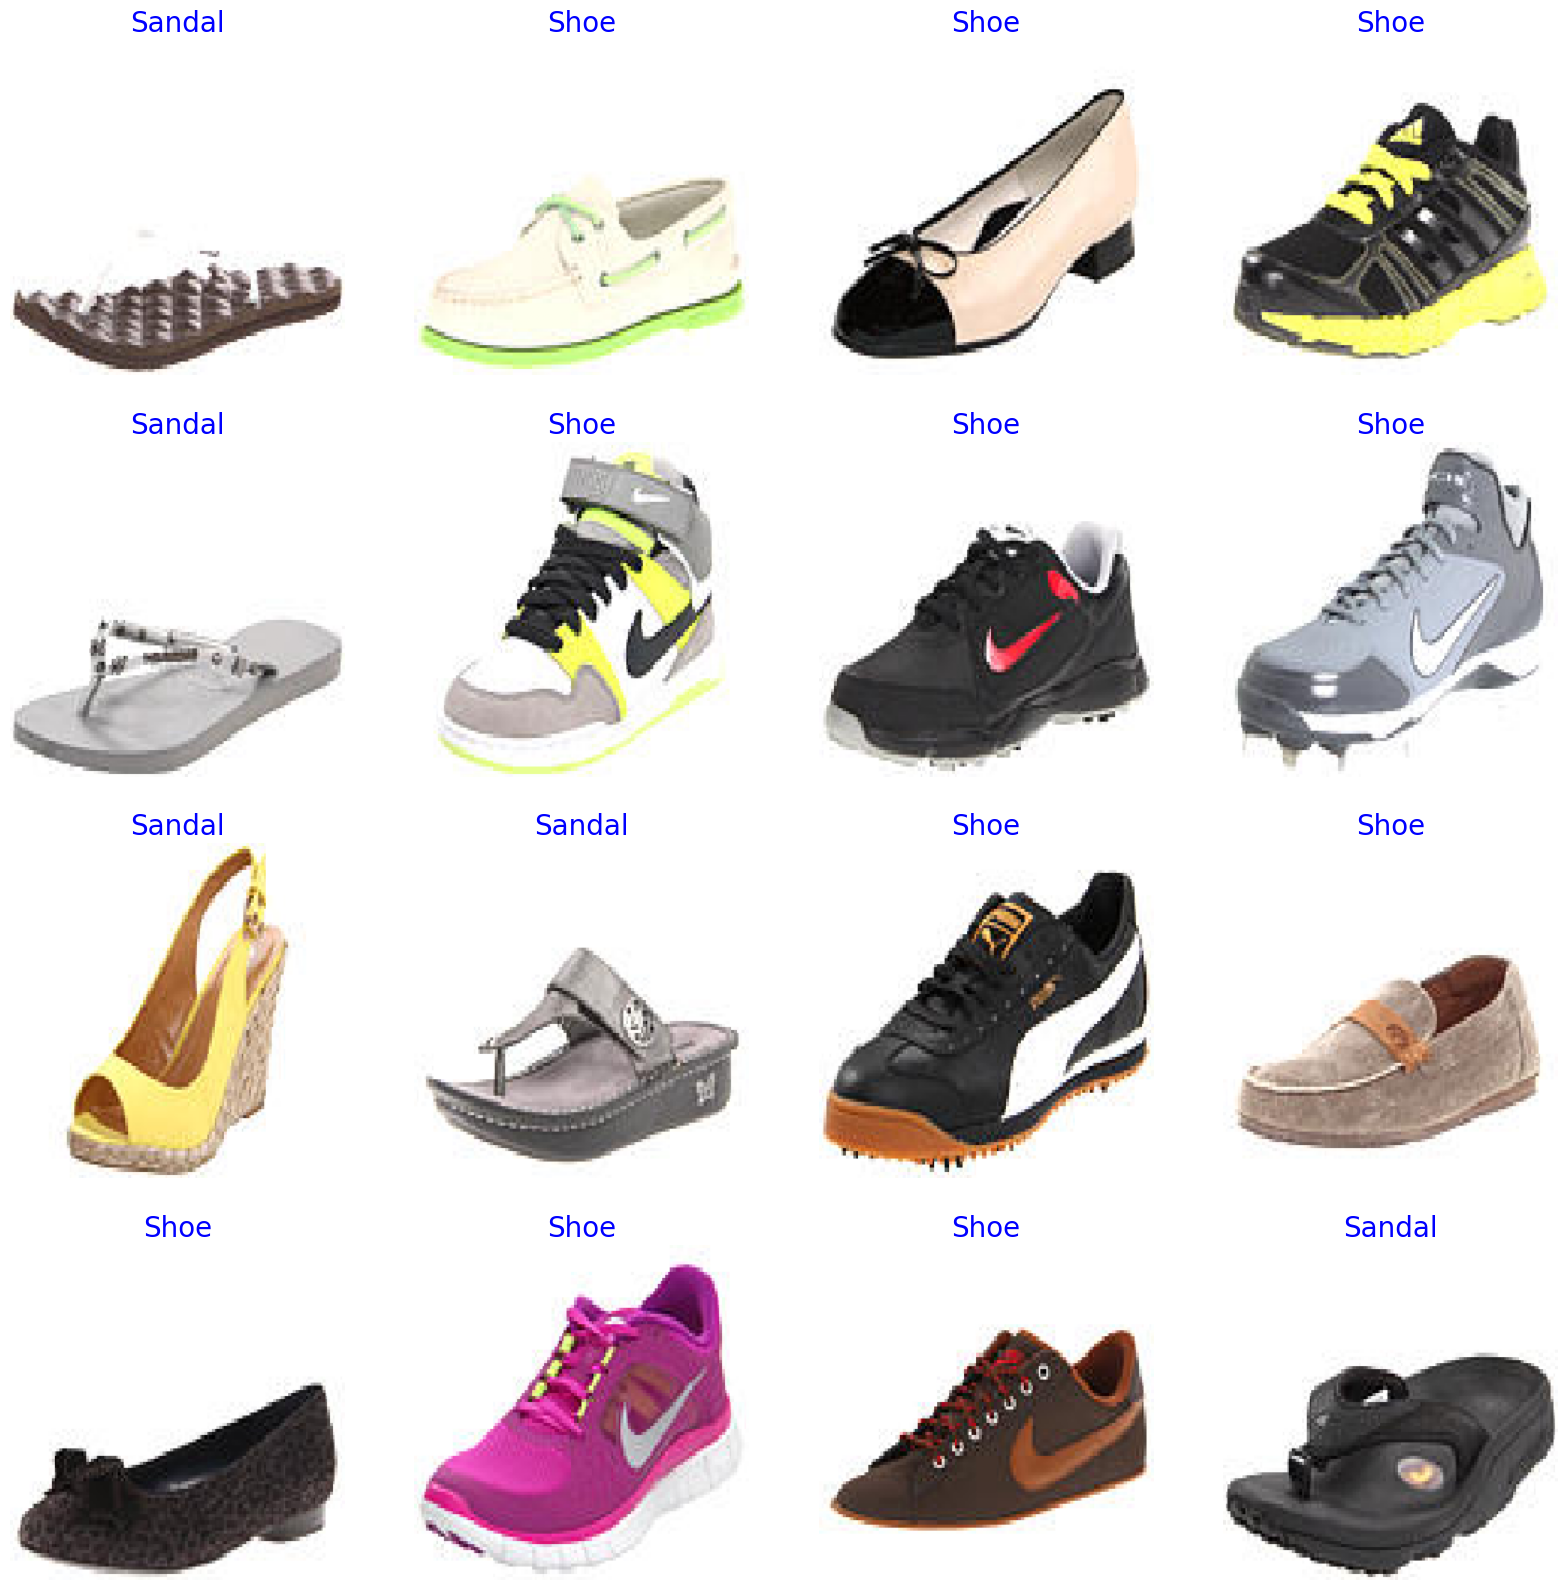

In [11]:
dict_gen = train_gen.class_indices
classes = list(dict_gen.keys())

images , labels = next(train_gen)

plt.figure(figsize = (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'Blue', fontsize = 20)
    plt.axis('off')

plt.show();

Model Structure

In [12]:
import splitfolders  # or import split_folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense

# ... (Previous code to split folders, define img_size, batches, tr_gen, ts_gen, train_gen, test_gen, val_gen) ...

channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(classes)

# Define the input shape explicitly
input_tensor = tf.keras.Input(shape=img_shape)

# Instantiate the base model
base_model = tf.keras.applications.ConvNeXtSmall(
    include_top=False,
    weights='imagenet',
    pooling='max',
    input_tensor=input_tensor  # Pass the input tensor to base_model
)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Build the Sequential model, adding a dummy input layer to help shape inference
model = Sequential([
    tf.keras.layers.InputLayer(input_shape=img_shape), # Dummy input layer
    base_model,
    BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001),
    Dense(256, activation='relu'),
    Dense(class_count, activation='softmax')
])

# Compile the model
model.compile(tf.keras.optimizers.Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Now call model.summary()
model.summary()

198551472/198551472 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ convnext_small (Functional)          │ (None, 768)                 │      49,454,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 768)                 │           3,072 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         196,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 49,655,395 (189.42 MB)

 Trainable params: 199,171 (778.01 KB)

 Non-trainable params: 49,456,224 (188.66 MB)

Iterate

In [13]:
epochs = 10
his = model.fit(x= train_gen , validation_data= val_gen , epochs = epochs , validation_steps= None ,verbose= 1,
               shuffle = False)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 136s 418ms/step - accuracy: 0.9377 - loss: 0.1753 - val_accuracy: 0.9820 - val_loss: 0.0524
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 240ms/step - accuracy: 0.9858 - loss: 0.0443 - val_accuracy: 0.9900 - val_loss: 0.0337
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 239ms/step - accuracy: 0.9912 - loss: 0.0283 - val_accuracy: 0.9910 - val_loss: 0.0339
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 239ms/step - accuracy: 0.9956 - loss: 0.0162 - val_accuracy: 0.9910 - val_loss: 0.0348
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 239ms/step - accuracy: 0.9960 - loss: 0.0148 - val_accuracy: 0.9900 - val_loss: 0.0319
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 241ms/step - accuracy: 0.9977 - loss: 0.0098 - val_accuracy: 0.9920 - val_loss: 0.0316
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 242ms/step - accuracy: 0.9990 - loss: 0.0078 - val_accuracy: 0.9900 - val_loss: 0.0399
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 239ms/step - accuracy: 0.9985 - loss: 

model performence

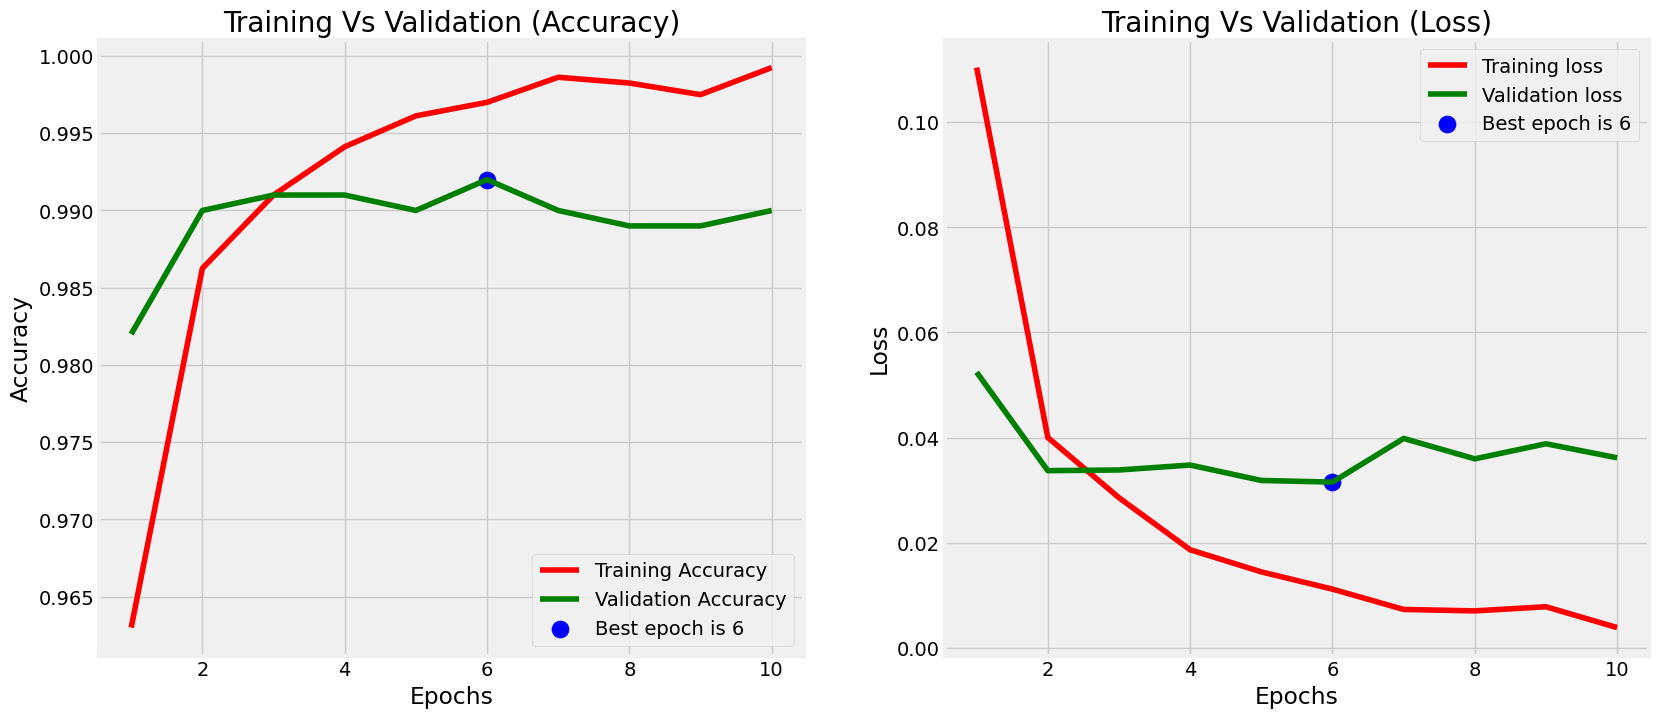

In [14]:
train_acc = his.history['accuracy']
train_loss = his.history['loss']

val_acc = his.history['val_accuracy']
val_loss = his.history['val_loss']

index_loss = np.argmin(val_loss)
index_acc = np.argmax(val_acc)

val_lowest = val_loss[index_loss]
val_highest = val_acc[index_acc]

epochs = [i+1 for i in range(len(train_acc))]
acc_label = f'Best epoch is {str(index_acc +1)}'
loss_label = f'Best epoch is {str(index_loss +1)}'

plt.figure(figsize = (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(epochs , train_acc , 'r' , label= 'Training Accuracy')
plt.plot(epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc+1 , val_highest , s = 150 , c = 'blue' , label = acc_label)
plt.title("Training Vs Validation (Accuracy)")
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs , train_loss , 'r' , label = "Training loss")
plt.plot(epochs , val_loss , 'g' , label = 'Validation loss')
plt.scatter(index_loss+1 , val_lowest , s = 150 , c= 'blue' , label = loss_label)
plt.title("Training Vs Validation (Loss)")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout
plt.show();

model evaluation

In [15]:
train_score = model.evaluate(train_gen , steps = 32 , verbose = 1)
valid_score = model.evaluate(val_gen , steps = 32 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 32 , verbose = 1)

print(f'Train Loss {train_score[0]} and Train Accuracy {train_score[1]}')
print(f'Validation Loss {valid_score[0]} and Validation Accuracy {valid_score[1]}')
print(f'Test Loss {test_score[0]} Test Accuracy {test_score[1]}')

32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - accuracy: 1.0000 - loss: 0.0010
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 202ms/step - accuracy: 0.9889 - loss: 0.0362
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - accuracy: 0.9871 - loss: 0.0405
Train Loss 0.0010353075340390205 and Train Accuracy 1.0
Validation Loss 0.03618119657039642 and Validation Accuracy 0.9900000095367432
Test Loss 0.03652895987033844 Test Accuracy 0.9879999756813049


model prediction

confusion mTRIX

In [16]:
preds = model.predict(test_gen)
y_pred = np.argmax(preds , axis = 1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 359ms/step


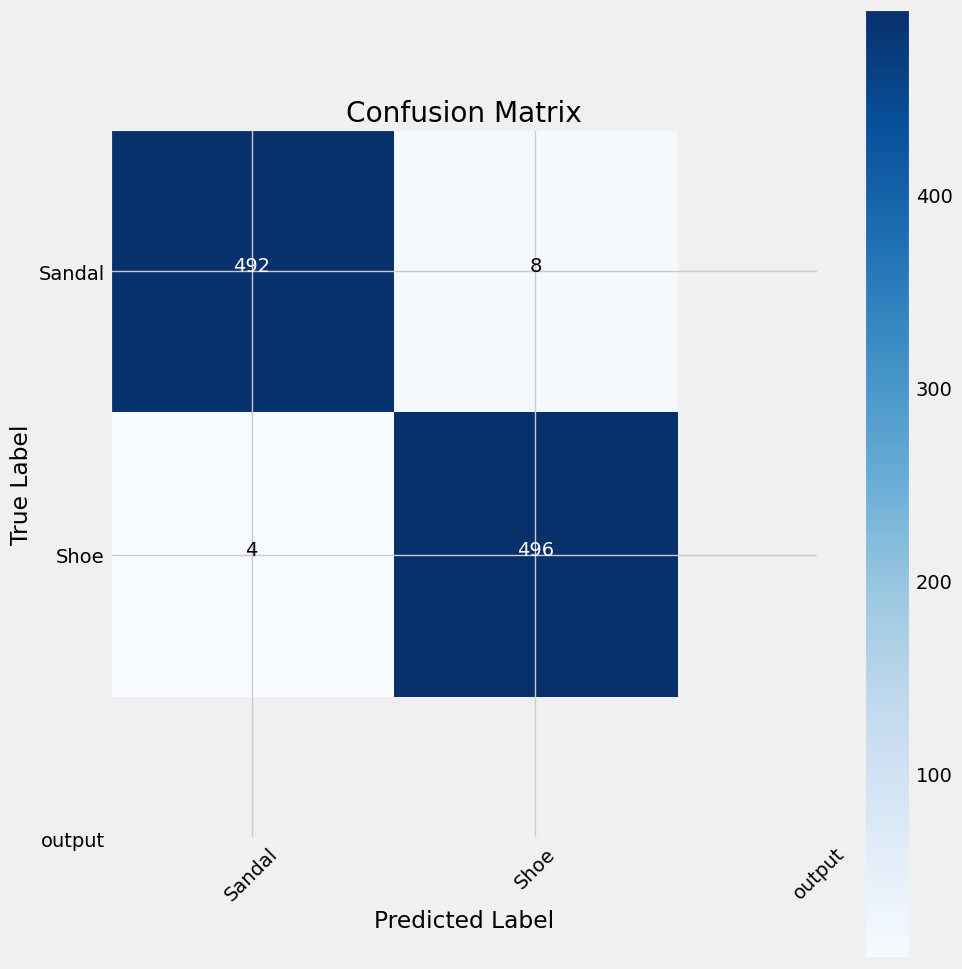

In [18]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
# Import the confusion_matrix function
from sklearn.metrics import confusion_matrix
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

classification report

In [20]:
from sklearn.metrics import classification_report
print(classification_report(test_gen.classes , y_pred , target_names = classes))

ValueError: Number of classes, 2, does not match size of target_names, 3. Try specifying the labels parameter

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 204ms/step


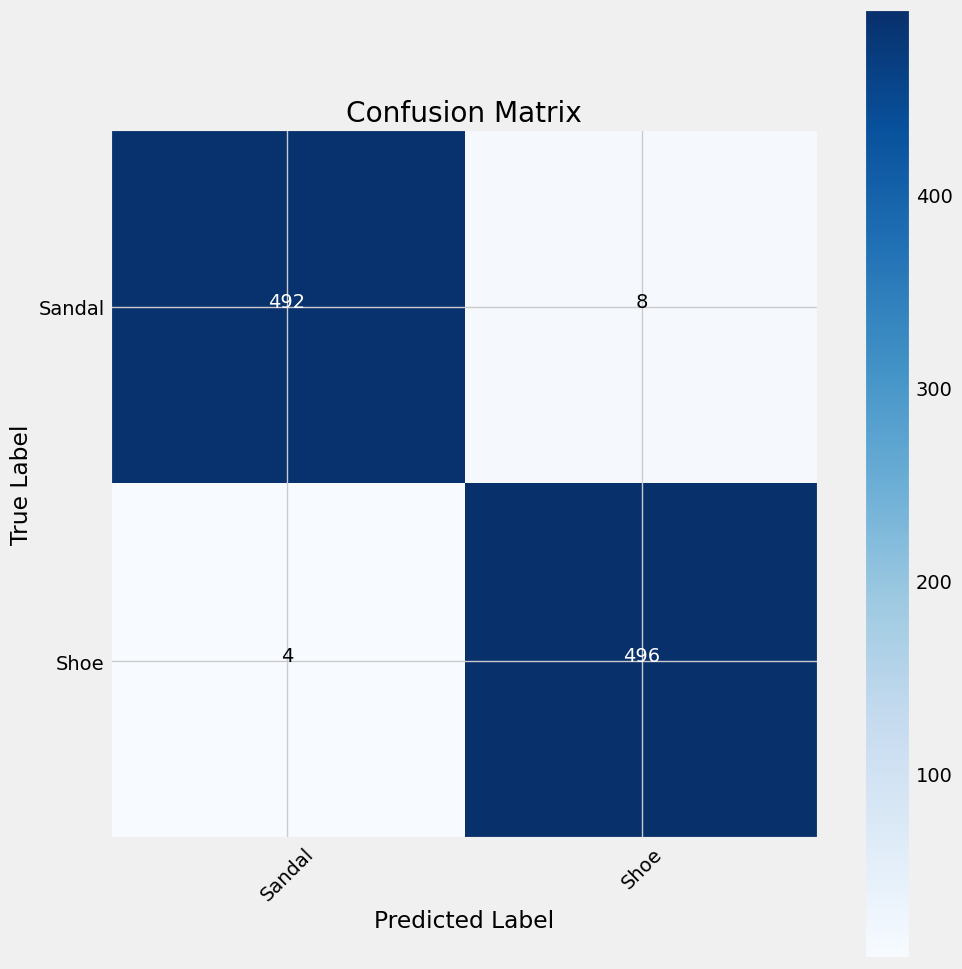

              precision    recall  f1-score   support

      Sandal       0.99      0.98      0.99       500
        Shoe       0.98      0.99      0.99       500

    accuracy                           0.99      1000
   macro avg       0.99      0.99      0.99      1000
weighted avg       0.99      0.99      0.99      1000



In [21]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Get the class indices and names from the generator
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Predict and get the predicted class labels
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

# Get the unique class labels from y_pred
unique_classes_in_y_pred = np.unique(y_pred)

# Filter target names to match the unique classes in y_pred
target_names = [classes[i] for i in unique_classes_in_y_pred]

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(target_names)) # Use filtered target names
plt.xticks(tick_marks, target_names, rotation=45) # Use filtered target names
plt.yticks(tick_marks, target_names) # Use filtered target names

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()


# Classification Report
# Use the filtered target_names and specify labels for clarity
print(classification_report(test_gen.classes, y_pred, target_names=target_names, labels=unique_classes_in_y_pred))